# 1.데이터 취합 자동화


In [2]:
APP_KEY = "PSDbkNNrIX3j60cW2MEFnBGZDZ1BzpgDxvC0"
APP_SECRET = "QfaZRX24K15ojO4yjG5o5dM+SUvJT4PYiK+tKKzgikyhmfrnTXoxOwn9rCf2hzXdtOhh4v3/O4bSFfQgS+u6ojdb6KgWuyub4GRraoWYaJTJyHSRqWUPab2GiCvrI/aIjx5S925MohrETq0k/eopFHgMInG0lmZdAh5TaegaZ1NDpNvPW8Y="
URL_BASE = "https://openapi.koreainvestment.com:9443"
PATH = "oauth2/tokenP"
URL = f"{URL_BASE}/{PATH}"

headers = {"content-type":"application/json"}
body = {"grant_type":"client_credentials",
        "appkey":APP_KEY, 
        "appsecret":APP_SECRET}

res = requests.post(URL, headers=headers, data=json.dumps(body))
ACCESS_TOKEN = res.json()["access_token"]

In [1]:
import re
import time
import pandas as pd
import json
import requests
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import tqdm
from bs4 import BeautifulSoup
from tqdm import tqdm
from datetime import datetime

#당일 시가 정보 불러오기
def find_gap(stock_code):
        time.sleep(0.05)
        URL = 'https://openapi.koreainvestment.com:9443/uapi/domestic-stock/v1/quotations/inquire-time-itemchartprice'

        headers = {"Content-Type":"application/json; charset=utf-8", 
                "authorization": f"Bearer {ACCESS_TOKEN}",
                "appKey":APP_KEY,
                "appSecret":APP_SECRET,
                "tr_id":"FHPST01060000"
                }

        params =  {
                "fid_cond_mrkt_div_code": "J",
                "fid_input_hour_1": "090030",
                "fid_input_iscd": stock_code
        }

        res = requests.get(URL, headers=headers, params=params)
        return res

#주식시세
def get_daily_info(stock_code):
    #api호출
    time.sleep(0.05)
    URL = 'https://openapi.koreainvestment.com:9443/uapi/domestic-stock/v1/quotations/inquire-daily-itemchartprice'

    headers = {"Content-Type":"application/json", 
            "authorization": f"Bearer {ACCESS_TOKEN}",
            "appKey":APP_KEY,
            "appSecret":APP_SECRET,
            "tr_id":"FHKST01010400"
            }

    params = {
        "FID_COND_MRKT_DIV_CODE":"J",
        "FID_INPUT_ISCD":f'{stock_code}',
        "fid_org_adj_prc": "0",
        "fid_period_div_code": "D"
    }
    #거래량, 저가 호출
    res = requests.get(URL, headers=headers, params=params)   
    res = res.json()
    res = res.get('output')[0:11]
    res.reverse()

    temp = pd.DataFrame(res).T
    temp.columns = [f'D_{i}' for i in range(10,-1,-1)]

    #당일 시가 및 고가
    daily_table = pd.DataFrame({
              'stck_oprc' :  temp['D_0']['stck_oprc'],
              'stck_hgpr'  : temp['D_0']['stck_hgpr'],
              },index=[0])
    
    #전일 저가,거래량(1일)
    b = ['stck_lwpr','acml_vol']
    for div in b:
        a = np.where(temp.index == f'{div}')[0][0]
        bin_table = temp.iloc[a:a+1,:].reset_index(drop=True)
        bin_table.columns = f'{div}_' + bin_table.columns
        daily_table = pd.concat([daily_table,bin_table],axis=1)

    return daily_table

#날짜호출
def get_date_info(stock_code):
    #api호출
    time.sleep(0.05)
    URL = 'https://openapi.koreainvestment.com:9443/uapi/domestic-stock/v1/quotations/inquire-daily-itemchartprice'

    headers = {"Content-Type":"application/json", 
            "authorization": f"Bearer {ACCESS_TOKEN}",
            "appKey":APP_KEY,
            "appSecret":APP_SECRET,
            "tr_id":"FHKST01010400"
            }

    params = {
        "FID_COND_MRKT_DIV_CODE":"J",
        "FID_INPUT_ISCD":f'{stock_code}',
        "fid_org_adj_prc": "0",
        "fid_period_div_code": "D"
    }
    #거래량, 저가 호출
    res = requests.get(URL, headers=headers, params=params)   
    res = res.json()
    date=res.get('output')[0].get('stck_bsop_date')

    return date

#한국투자 API 보안 인증키 발급 
APP_KEY = "PSDbkNNrIX3j60cW2MEFnBGZDZ1BzpgDxvC0"
APP_SECRET = "QfaZRX24K15ojO4yjG5o5dM+SUvJT4PYiK+tKKzgikyhmfrnTXoxOwn9rCf2hzXdtOhh4v3/O4bSFfQgS+u6ojdb6KgWuyub4GRraoWYaJTJyHSRqWUPab2GiCvrI/aIjx5S925MohrETq0k/eopFHgMInG0lmZdAh5TaegaZ1NDpNvPW8Y="
URL_BASE = "https://openapi.koreainvestment.com:9443"
PATH = "oauth2/tokenP"
URL = f"{URL_BASE}/{PATH}"

headers = {"content-type":"application/json"}
body = {"grant_type":"client_credentials",
        "appkey":APP_KEY, 
        "appsecret":APP_SECRET}

res = requests.post(URL, headers=headers, data=json.dumps(body))
ACCESS_TOKEN = res.json()["access_token"]

#주가 기본정보 불러오기
Kospi_df = pd.read_csv('data/kospi_code.csv')
Kosdaq_df = pd.read_csv('data/kosdaq_code.csv')
#코스피 분류
kospi = Kospi_df.filter(items= ['단축코드','한글명'])
kospi['class'] = 'kospi'
#코스닥 분류
kosdaq = Kosdaq_df.filter(items= ['단축코드','한글종목명'])
kosdaq['class'] = 'kospi'
#주가 종목코드 불러오기
kospi = kospi.rename(columns={'단축코드':'stock_code','한글명' : 'stock_name'})
kosdaq = kosdaq.rename(columns={'단축코드':'stock_code','한글종목명' : 'stock_name'})
kospi_kosdaq = pd.concat([kospi,kosdaq])
kospi_kosdaq = kospi_kosdaq.reset_index(drop=True)

#개장 직후 종목 검색
data = pd.DataFrame()
for i in tqdm(range(len(kospi_kosdaq))):
    stock_code = kospi_kosdaq.stock_code[i]
    stock_name = kospi_kosdaq.stock_name[i]
    stock_class = kospi_kosdaq['class'][i]
    res = find_gap(stock_code)
    try : 
        gap_per = res.json().get('output2')[-1].get('prdy_ctrt')
        gap_hour = res.json().get('output2')[-1].get('stck_cntg_hour')
        temp = pd.DataFrame({
                        'stock_code': stock_code,
                        'stock_name': stock_name,
                        'stock_class' : stock_class,
                        'gap_per': gap_per,
                        'gap_hour': gap_hour,
                        }, index=[0])
        data = pd.concat([data,temp],axis=0)
    except :
        pass
data = data.reset_index(drop=True)
data['gap_int'] = data.gap_per.apply(lambda x: float(x))
stock2 = data.query('gap_int >= 2.0').reset_index(drop=True)

#종목별 정보 받아오기
daily_stock = pd.DataFrame()
for i in tqdm(stock2.stock_code):
    daily_table = get_daily_info(i)
    daily_stock = pd.concat([daily_stock, daily_table])

#전체 합치기
daily_stock = daily_stock.reset_index(drop=True)
stock2 = pd.concat([stock2,daily_stock],axis=1)

#날짜호출
date = get_date_info(stock_code)

#데이터 인트타입으로 변환
for cn in stock2.columns[5:]:
    stock2[f'{cn}'] = stock2[f'{cn}'].apply(lambda x : float(x))

#증가율
stock2['gap_change'] = stock2['gap_int']

#거래량추이
ex_volume = stock2.iloc[:,18:28]

#이상치 범위 설정 
q3 = ex_volume.quantile(0.75, axis=1)
q1 = ex_volume.quantile(0.25, axis=1)

IQR = q3-q1
upper_limit = q3 + 1.5*IQR

#이상치 범위 변환
upper_limit = pd.DataFrame(upper_limit).to_numpy()
ex_volume = ex_volume.to_numpy()
ex_volume = np.where(ex_volume>upper_limit,np.nan,ex_volume)
ex_volume = pd.DataFrame(ex_volume)
stock2['mean_vlome'] = ex_volume.mean(axis=1)
stock2['today_vlome'] = stock2.acml_vol_D_0.apply(lambda x : int(x))
stock2['volume_change'] = stock2.iloc[:,28:].pct_change(axis=1)['today_vlome']

#저점 상승도
parameter = stock2.iloc[:,5:15]
parameter = parameter.T

for i in range(len(parameter.columns)):
    name = f'price{i}' 
    parameter = parameter.rename(columns={i:name})

parameter = parameter.reset_index().drop(columns=['index'])
parameter = parameter.reset_index()

data2=pd.DataFrame()
for i in range(0,len(stock2)):
    model = sm.OLS.from_formula(f'index ~ price{i}', parameter).fit()
    slope = model.params[f'price{i}']
    temp = pd.DataFrame({'slope': slope} ,index =[i])
    data2 = pd.concat([data2,temp])
stock2['slope'] = data2

#상승여부 판단
stock2['day_change'] = stock2['stck_hgpr'] - stock2['stck_oprc']
stock2['deter_change'] = stock2.day_change.apply(lambda x : 1 if x > 0 else 0)
stock2['day_change_per'] = stock2.filter(items=['stck_oprc','stck_hgpr']).pct_change(axis=1)['stck_hgpr']

#데이터저장
stock2.to_csv(f'./data/{date}.csv', index=False, encoding='utf-8-sig')

100%|██████████| 352/352 [00:34<00:00, 10.09it/s]


In [12]:
stock2.to_csv(f'./data/{date}.csv', index=False, encoding='utf-8-sig')

# 2.결과해석(당일)

[     gap_change    mean_vlome  today_vlome  volume_change     slope  \
0          2.19  8.840760e+04       501209       4.669298  0.000583   
1          3.59  1.952222e+02          275       0.408651  0.000353   
2          3.20  7.872110e+05      1491465       0.894619  0.001576   
3          2.75  9.681555e+05       838835      -0.133574  0.009087   
4          2.76  1.022236e+05       704352       5.890310  0.000093   
..          ...           ...          ...            ...       ...   
108        9.12  1.268981e+06      1874439       0.477121  0.000048   
109        3.65  7.087195e+05      2947559       3.158992  0.000127   
110        2.11  1.219738e+05       440452       2.611039  0.002088   
111        2.02  2.455041e+06      3170764       0.291532  0.000179   
112        4.49  7.421133e+04      2734182      35.843187  0.000183   

     day_change  deter_change  day_change_per  
0            40             1        0.005013  
1             0             0        0.000000  
2 

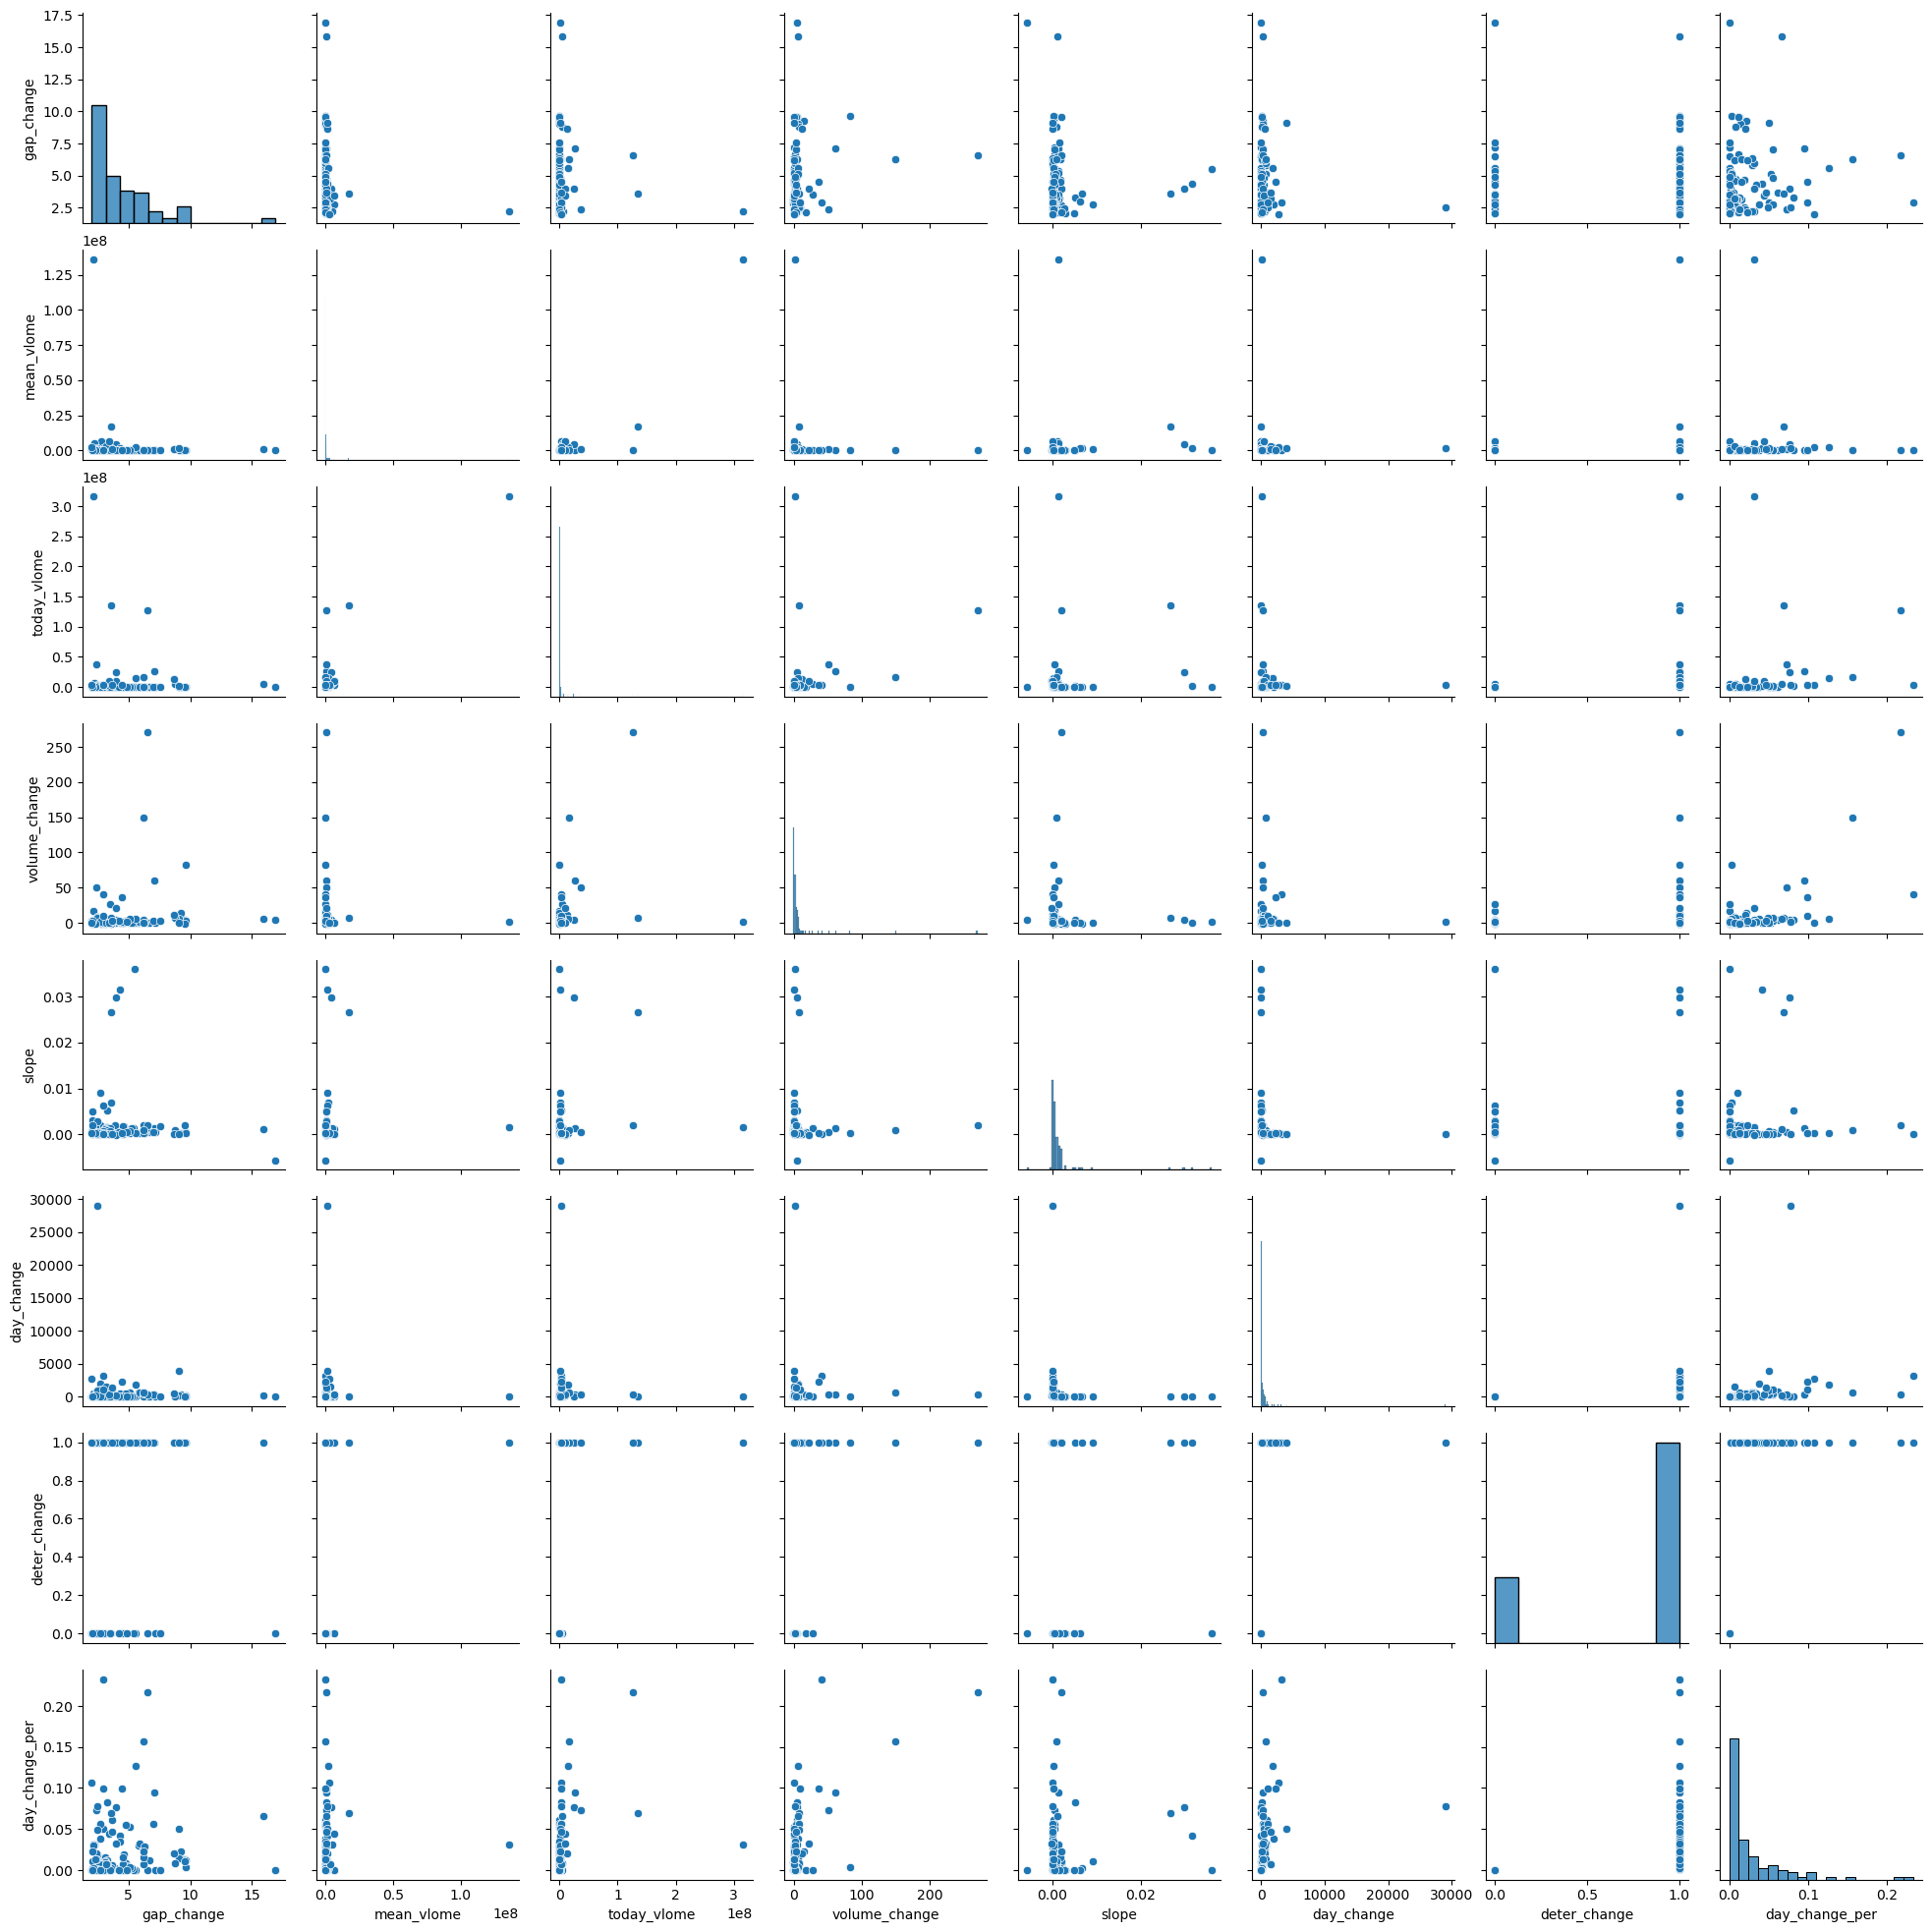

In [13]:
stock_data = stock2.iloc[:,30:]
print([stock_data])

%matplotlib inline
sns.pairplot(stock_data)



In [9]:
stock2

,stock_code,stock_name,stock_class,gap_per,gap_hour,gap_int,stck_oprc,stck_hgpr,stck_lwpr_D_10,stck_lwpr_D_9,...,acml_vol_D_1,acml_vol_D_0,gap_change,mean_vlome,today_vlome,volume_change,slope,day_change,deter_change,day_change_per
0,002350,넥센타이어,kospi,2.19,090017,2,7980,8020,7490,7500,...,1508394,501209,2,8.840760e+04,501209,4.669298,0.000583,40,1,0.005013
1,002787,진흥기업2우B,kospi,3.59,090024,3,13570,13570,13250,13250,...,432,275,3,1.952222e+02,275,0.408651,0.000353,0,0,0.000000
2,003530,한화투자증권,kospi,3.20,090020,3,2885,2920,3040,3045,...,878187,1491465,3,7.872110e+05,1491465,0.894619,0.001576,35,1,0.012132
3,005030,부산주공,kospi,2.75,090014,2,485,490,522,530,...,927413,838835,2,9.681555e+05,838835,-0.133574,0.009087,5,1,0.010309
4,010120,LS ELECTRIC,kospi,2.76,090024,2,52000,54000,49750,50200,...,111058,704352,2,1.022236e+05,704352,5.890310,0.000093,2000,1,0.038462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,383310,에코프로에이치엔,kospi,9.12,090030,9,78000,81900,50000,51100,...,418084,1874439,9,1.268981e+06,1874439,0.477121,0.000048,3900,1,0.050000
109,388720,유일로보틱스,kospi,3.65,090029,3,31200,32650,25500,26950,...,1335245,2947559,3,7.087195e+05,2947559,3.158992,0.000127,1450,1,0.046474
110,389030,지니너스,kospi,2.11,090012,2,2420,2475,2220,2300,...,171619,440452,2,1.219738e+05,440452,2.611039,0.002088,55,1,0.022727
111,407400,꿈비,kospi,2.02,090022,2,25200,27900,19000,18870,...,957816,3170764,2,2.455041e+06,3170764,0.291532,0.000179,2700,1,0.107143


In [14]:
stock_data

,gap_change,mean_vlome,today_vlome,volume_change,slope,day_change,deter_change,day_change_per
0,2.19,8.840760e+04,501209,4.669298,0.000583,40,1,0.005013
1,3.59,1.952222e+02,275,0.408651,0.000353,0,0,0.000000
2,3.20,7.872110e+05,1491465,0.894619,0.001576,35,1,0.012132
3,2.75,9.681555e+05,838835,-0.133574,0.009087,5,1,0.010309
4,2.76,1.022236e+05,704352,5.890310,0.000093,2000,1,0.038462
...,...,...,...,...,...,...,...,...
108,9.12,1.268981e+06,1874439,0.477121,0.000048,3900,1,0.050000
109,3.65,7.087195e+05,2947559,3.158992,0.000127,1450,1,0.046474
110,2.11,1.219738e+05,440452,2.611039,0.002088,55,1,0.022727
111,2.02,2.455041e+06,3170764,0.291532,0.000179,2700,1,0.107143


In [21]:
model = sm.OLS.from_formula('day_change_per ~ gap_change + +mean_vlome + today_vlome+  volume_change + slope ', stock_data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         day_change_per   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                     14.39
Date:                Tue, 14 Mar 2023   Prob (F-statistic):           9.12e-11
Time:                        20:45:50   Log-Likelihood:                 231.52
No. Observations:                 113   AIC:                            -451.0
Df Residuals:                     107   BIC:                            -434.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0197      0.006      3.217      0.002       0.008       0.032
gap_change       -0.0003      0.001     -0.258      0.797      -0.003       0.002
mean_vlome    -5.454e-10   7.76e-10     -0.703      0.483   -2.08e-09    9.92e-10
today_vlome    2.904e-10   3.09e-10      0.939      0.350   -3.22e-10    9.03e-10
volume_change     0.0007      0.000      4.764      0.000       0.000       0.001
slope             0.3431      0.568      0.604      0.547      -0.783       1.469
==============================================================================
Omnibus:                       85.462   Durbin-Watson:                   1.618
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              635.937
Skew:                           2.522   Prob(JB):                    8.09e-139
Kurtosis:                      13.470   Cond. No.                     6.95e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.95e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [20]:
Y = stock_data['deter_change']
X = stock_data[['today_vlome', ]]

X = sm.add_constant(X)
model = sm.Logit(Y,X)
results = model.fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.514412
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:           deter_change   No. Observations:                  113
Model:                          Logit   Df Residuals:                      111
Method:                           MLE   Df Model:                            1
Date:                Tue, 14 Mar 2023   Pseudo R-squ.:                 0.08123
Time:                        20:45:10   Log-Likelihood:                -58.129
converged:                       True   LL-Null:                       -63.268
Covariance Type:            nonrobust   LLR p-value:                  0.001346
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.7162      0.252      2.844      0.004       0.223       1.210
today_vlome  4.292e-07   

In [17]:
Y = stock_data['deter_change']
X = stock_data[['today_vlome', 'slope']]

X = sm.add_constant(X)
model = sm.Logit(Y,X)
results = model.fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.368810
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:           deter_change   No. Observations:                  127
Model:                          Logit   Df Residuals:                      124
Method:                           MLE   Df Model:                            2
Date:                Thu, 09 Mar 2023   Pseudo R-squ.:                  0.4136
Time:                        17:26:48   Log-Likelihood:                -46.839
converged:                       True   LL-Null:                       -79.881
Covariance Type:            nonrobust   LLR p-value:                 4.465e-15
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.1675      0.324     -0.517      0.605      -0.803       0.468
today_vlome   3.57e-06   

In [32]:
np.set_printoptions(precision=6, suppress=True)

In [6]:
pd.options.display.float_format = '{:.3f}'.format

In [13]:
stock['day_change_per'] = stock.filter(items=['stck_oprc','stck_hgpr']).pct_change(axis=1)['stck_hgpr']

# 3.결과해석(누적)

In [3]:
stock1 = pd.read_csv('data/20230308.csv')
stock2 = pd.read_csv('data/20230309.csv')

In [4]:
stock = pd.concat([stock1,stock2])
stock

,stock_code,stock_name,gap_per,gap_hour,gap_int,stck_oprc,stck_hgpr,stck_lwpr_D_10,stck_lwpr_D_9,stck_lwpr_D_8,...,acml_vol_D_2,acml_vol_D_1,acml_vol_D_0,gap_change,mean_vlome,today_vlome,volume_change,slope,day_change,deter_change
0,000545,흥국화재우,2.60,90013,2.60,7100,7100,6710,6730,6800,...,4191,846,4008,2.00,3.765600e+03,4008,0.064372,0.004595,0,0
1,001390,KG케미칼,3.15,90029,3.15,34350,35600,24450,23400,23400,...,170560,3990677,3728552,3.00,1.125631e+05,3728552,32.124102,-0.000425,1250,1
2,006220,제주은행,7.26,90030,7.26,23250,23800,21950,22000,21200,...,677734,2278055,2196036,7.00,1.938465e+06,2196036,0.132874,-0.002273,550,1
3,006570,대림통상,3.09,90029,3.09,4005,5050,3870,3830,3750,...,5322,5748,1334669,3.00,5.073500e+03,1334669,262.066719,-0.003861,1045,1
4,017040,광명전기,3.85,90025,3.85,2595,2650,2395,2360,2370,...,439264,1245182,6365970,3.00,3.402592e+05,6365970,17.709177,-0.018137,55,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,382900,범한퓨얼셀,2.25,90019,2.25,29500,31200,28100,28350,28650,...,119954,67022,378792,2.25,7.873600e+04,378792,3.810912,-0.001766,1700,1
123,383930,디티앤씨알오,5.73,90029,5.73,6890,7400,5750,5675,5800,...,512304,554700,1123362,5.73,3.618316e+05,1123362,2.104654,-0.003182,510,1
124,394280,오픈엣지테크놀로지,3.66,90028,3.66,23950,25400,21600,23600,24200,...,1592968,1260938,3449832,3.66,3.325188e+06,3449832,0.037485,-0.001041,1450,1
125,402030,코난테크놀로지,2.15,90006,2.15,132900,138200,99500,104000,121300,...,132910,176148,367741,2.15,3.977720e+05,367741,-0.075498,0.000076,5300,1


In [14]:
stock_data = stock.iloc[:,29:]
stock_data.query('deter_change == 1')


,gap_change,mean_vlome,today_vlome,volume_change,slope,day_change,deter_change,day_change_per
1,3.000,112563.111,3728552,32.124,-0.000,1250,1,0.036
2,7.000,1938465.300,2196036,0.133,-0.002,550,1,0.024
3,3.000,5073.500,1334669,262.067,-0.004,1045,1,0.261
4,3.000,340259.222,6365970,17.709,-0.018,55,1,0.021
5,6.000,553323.200,6578029,10.888,-0.044,72,1,0.053
...,...,...,...,...,...,...,...,...
121,3.400,597281.600,648138,0.085,-0.000,700,1,0.013
122,2.250,78736.000,378792,3.811,-0.002,1700,1,0.058
123,5.730,361831.600,1123362,2.105,-0.003,510,1,0.074
124,3.660,3325188.000,3449832,0.037,-0.001,1450,1,0.061


In [19]:
model = sm.OLS.from_formula('day_change_per ~ gap_change + volume_change ', stock_data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         day_change_per   R-squared:                       0.324
Model:                            OLS   Adj. R-squared:                  0.318
Method:                 Least Squares   F-statistic:                     55.64
Date:                Thu, 09 Mar 2023   Prob (F-statistic):           1.82e-20
Time:                        21:49:06   Log-Likelihood:                 449.55
No. Observations:                 235   AIC:                            -893.1
Df Residuals:                     232   BIC:                            -882.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0134      0.004      3.374      0.001       0.006       0.021
gap_change        0.0016      0.001      2.052      0.041    6.29e-05       0.003
volume_change     0.0012      0.000     10.061      0.000       0.001       0.001
==============================================================================
Omnibus:                      148.152   Durbin-Watson:                   1.735
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1003.138
Skew:                           2.521   Prob(JB):                    1.48e-218
Kurtosis:                      11.777   Cond. No.                         33.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [25]:
Y = stock_data['deter_change']
X = stock_data[['gap_change', 'mean_vlome', 'today_vlome', 'volume_change', 'slope']]

X = sm.add_constant(X)
model = sm.Logit(Y,X)
results = model.fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.408157
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:           deter_change   No. Observations:                  235
Model:                          Logit   Df Residuals:                      229
Method:                           MLE   Df Model:                            5
Date:                Thu, 09 Mar 2023   Pseudo R-squ.:                  0.3171
Time:                        17:32:33   Log-Likelihood:                -95.917
converged:                       True   LL-Null:                       -140.46
Covariance Type:            nonrobust   LLR p-value:                 1.043e-17
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.4269      0.306      1.393      0.164      -0.174       1.028
gap_change        0

In [30]:
Y = stock_data['deter_change']
X = stock_data[['today_vlome', 'slope']]

X = sm.add_constant(X)
model = sm.Logit(Y,X)
results = model.fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.408430
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:           deter_change   No. Observations:                  235
Model:                          Logit   Df Residuals:                      232
Method:                           MLE   Df Model:                            2
Date:                Thu, 09 Mar 2023   Pseudo R-squ.:                  0.3167
Time:                        17:35:06   Log-Likelihood:                -95.981
converged:                       True   LL-Null:                       -140.46
Covariance Type:            nonrobust   LLR p-value:                 4.809e-20
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.4636      0.185      2.508      0.012       0.101       0.826
today_vlome  2.009e-06   

# 5. 추후과제
- slope 재산정 : 코스피,코스닥의 저점추세 혹은 업종 저점추세와 비교
- 선형회귀분석식 산정 : 

# 6. slope 재산정

In [23]:
URL = 'https://openapi.koreainvestment.com:9443/uapi/domestic-stock/v1/quotations/inquire-time-itemchartprice'

headers = {"Content-Type":"application/json; charset=utf-8", 
        "authorization": f"Bearer {ACCESS_TOKEN}",
        "appKey":APP_KEY,
        "appSecret":APP_SECRET,
        "tr_id":"FHKUP03500100"
        }

params =  {
          "fid_cond_mrkt_div_code": "U",
            "fid_input_date_1": "20220411",
            "fid_input_date_2": "20220509",
            "fid_input_iscd": "0001",
            "fid_period_div_code": "D"
}

res = requests.get(URL, headers=headers, params=params)

In [33]:
kospi_index

,index,bstp_nmix_lwpr
0,0,2606.08
1,1,2635.97
2,2,2667.23
3,3,2680.46
4,4,2667.85
5,5,2664.06
6,6,2638.37
7,7,2615.50
8,8,2663.83
9,9,2657.04


In [37]:
kospi_index = pd.DataFrame(res.json().get('output2')).reset_index()
kospi_index = kospi_index.filter(items=['index','bstp_nmix_lwpr'])
kospi_index['bstp_nmix_lwpr'] = kospi_index.bstp_nmix_lwpr.apply(lambda x : float(x))

model = sm.OLS.from_formula(f'index ~ bstp_nmix_lwpr', kospi_index).fit()
# slope = model.params[f'price{i}']

In [40]:
model.params['bstp_nmix_lwpr']

0.10804866549074264